### Classify bird data set with TensorFlow.  Project images to 3-D and visualize that in TensorBoard.

In [1]:
import os,cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import regularizers
from keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [2]:
data_path = 'data'
data_dir_list = os.listdir(data_path)
print(data_dir_list)

['test', 'train', 'validation']


In [3]:
train_path = os.path.join(data_path,"train")
train_dir_list = os.listdir(train_path)
print(train_dir_list)

['FLAME TANAGER', 'GOULDIAN FINCH', 'INDIGO BUNTING', 'LILAC ROLLER', 'MALACHITE KINGFISHER', 'NICOBAR PIGEON', 'PAINTED BUNTIG', 'PEACOCK', 'RAINBOW LORIKEET', 'TAIWAN MAGPIE']


In [4]:
validation_path = os.path.join(data_path,"validation")
validation_dir_list = os.listdir(validation_path)
print(validation_dir_list)

['FLAME TANAGER', 'GOULDIAN FINCH', 'INDIGO BUNTING', 'LILAC ROLLER', 'MALACHITE KINGFISHER', 'NICOBAR PIGEON', 'PAINTED BUNTIG', 'PEACOCK', 'RAINBOW LORIKEET', 'TAIWAN MAGPIE']


In [5]:
test_path = os.path.join(data_path,"test")
test_dir_list = os.listdir(test_path)
print(test_dir_list)

['FLAME TANAGER', 'GOULDIAN FINCH', 'INDIGO BUNTING', 'LILAC ROLLER', 'MALACHITE KINGFISHER', 'NICOBAR PIGEON', 'PAINTED BUNTIG', 'PEACOCK', 'RAINBOW LORIKEET', 'TAIWAN MAGPIE']


Found 1100 images belonging to 10 classes.


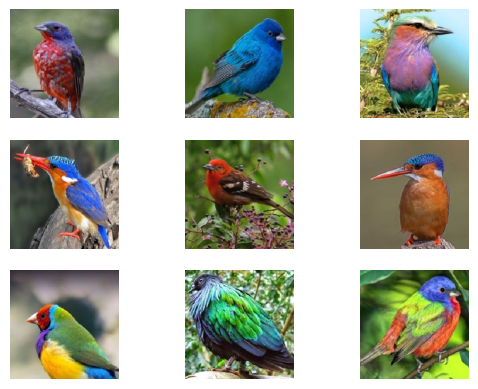

In [6]:
#-----------------------------------------------------------
# Visualizing some sample data
#-----------------------------------------------------------

sample_generator = ImageDataGenerator().flow_from_directory(train_path, shuffle=True)

plt.figure()
for i in range(9):
    # 3x3 grid
    sp=plt.subplot(330 + 1 + i)
    sp.axis('Off') # Don't show axes (or gridlines)
    batch = sample_generator.next()[0]
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [7]:
#-----------------------------------------------------------
# Prepare a csv file with training data
#-----------------------------------------------------------

class_to_labels={'FLAME TANAGER':0,'GOULDIAN FINCH':1,'INDIGO BUNTING':2,'LILAC ROLLER':3,'MALACHITE KINGFISHER':4, 
                 'NICOBAR PIGEON':5,'PAINTED BUNTIG':6,'PEACOCK':7,'RAINBOW LORIKEET':8, 'TAIWAN MAGPIE':9 }

df = pd.DataFrame(columns=['img_names', 'labels', 'class_names'])

for dataset in train_dir_list:
    img_list=os.listdir(os.path.join(train_path, dataset))
    print ('Loading dataset-'+'{}\n'.format(dataset))
    label=class_to_labels[dataset]
    for img in img_list:
        img_name=os.path.join(train_path,dataset,img)
       # annotations.append([image_name,dataset,label])
        df = df.append({'img_names': img_name, 'labels': label,'class_names': dataset},ignore_index=True)

df.to_csv(os.path.join('data_annotations.csv'))

Loading dataset-FLAME TANAGER

Loading dataset-GOULDIAN FINCH

Loading dataset-INDIGO BUNTING

Loading dataset-LILAC ROLLER

Loading dataset-MALACHITE KINGFISHER

Loading dataset-NICOBAR PIGEON

Loading dataset-PAINTED BUNTIG

Loading dataset-PEACOCK

Loading dataset-RAINBOW LORIKEET

Loading dataset-TAIWAN MAGPIE



In [8]:
#-----------------------------------------------------------
# Preparing the ImageDataGenerator
#-----------------------------------------------------------

train_imagedatagenerator = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_imagedatagenerator = ImageDataGenerator(rescale=1.0/255.)

train_iterator = train_imagedatagenerator.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='sparse')

validation_iterator = validation_imagedatagenerator.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='sparse')

dirs = train_iterator.class_indices
rdirs = {v:k  for k,v in dirs.items()}

Found 1100 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [9]:
#-----------------------------------------------------------
# Creating the Deep Learning Model
#-----------------------------------------------------------

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2), 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2), 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2), 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.001)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [10]:
#-----------------------------------------------------------
# Compiling the model
#-----------------------------------------------------------

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       7

In [11]:
#-----------------------------------------------------------
# Early stopping
#-----------------------------------------------------------

from keras.callbacks import ModelCheckpoint, EarlyStopping

metric = 'val_accuracy'
checkpoint = ModelCheckpoint(
    filepath=r"<path>/{}".format("myModel"), 
    monitor=metric,
    verbose=2, 
    save_best_only=True, 
    mode='max')

early = EarlyStopping(
    monitor=metric, 
    min_delta=0, 
    patience=5, 
    verbose=2, 
    mode='auto')

In [12]:
#-----------------------------------------------------------
# Training the model
#-----------------------------------------------------------

history = model.fit(
    train_iterator,
    validation_data=validation_iterator,
    #steps_per_epoch=100, #steps_per_epoch=(data_samples/batch_size),
    epochs=80,
    validation_steps=10,
    callbacks=[checkpoint,early],
    verbose=2)

Epoch 1/80
55/55 - 38s - loss: 2.8334 - accuracy: 0.2718 - val_loss: 2.1111 - val_accuracy: 0.3300

Epoch 00001: val_accuracy improved from -inf to 0.33000, saving model to C:/Users/AGM/HW3_tensorBoard\myModel
INFO:tensorflow:Assets written to: C:/Users/AGM/HW3_tensorBoard\myModel\assets
Epoch 2/80
55/55 - 20s - loss: 2.0926 - accuracy: 0.4255 - val_loss: 1.6553 - val_accuracy: 0.6100

Epoch 00002: val_accuracy improved from 0.33000 to 0.61000, saving model to C:/Users/AGM/HW3_tensorBoard\myModel
INFO:tensorflow:Assets written to: C:/Users/AGM/HW3_tensorBoard\myModel\assets
Epoch 3/80
55/55 - 24s - loss: 1.8002 - accuracy: 0.5418 - val_loss: 1.4112 - val_accuracy: 0.6750

Epoch 00003: val_accuracy improved from 0.61000 to 0.67500, saving model to C:/Users/AGM/HW3_tensorBoard\myModel
INFO:tensorflow:Assets written to: C:/Users/AGM/HW3_tensorBoard\myModel\assets
Epoch 4/80
55/55 - 19s - loss: 1.6225 - accuracy: 0.5855 - val_loss: 1.4462 - val_accuracy: 0.6800

Epoch 00004: val_accuracy i

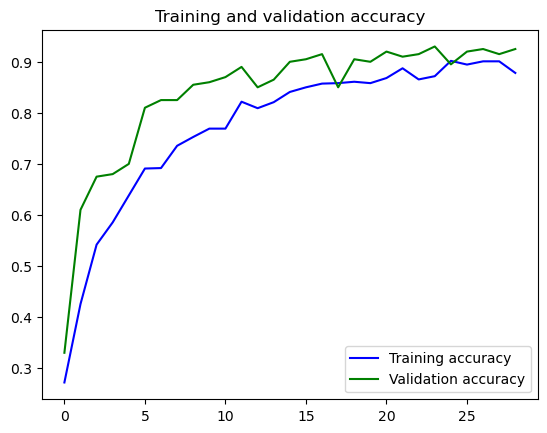

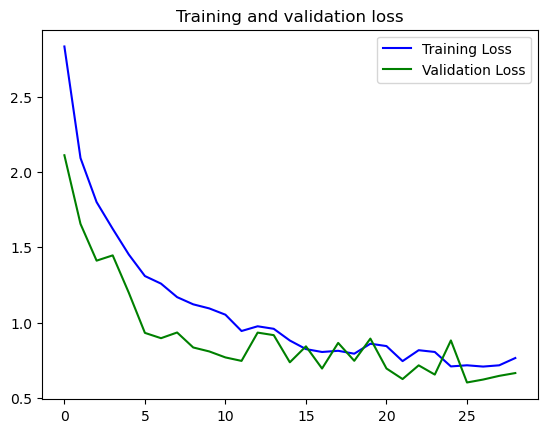

In [13]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
plot_result(history)

In [14]:
#-----------------------------------------------------------
# Load the best saved model and pre-process the image and pass the image to the model for output.
#-----------------------------------------------------------

from keras.models import load_model

saved_model = load_model("<path>/myModel")

In [15]:
#-----------------------------------------------------------
# creating new model by eliminating the last layer
#-----------------------------------------------------------

from tensorflow.keras.models import Sequential

cust_model = Sequential()
for layer in saved_model.layers[:-2]: # just exclude last layer from copying
    cust_model.add(layer)
    
cust_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)      

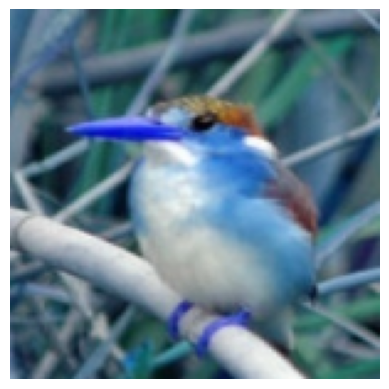

predict: INDIGO BUNTING actual: MALACHITE KINGFISHER


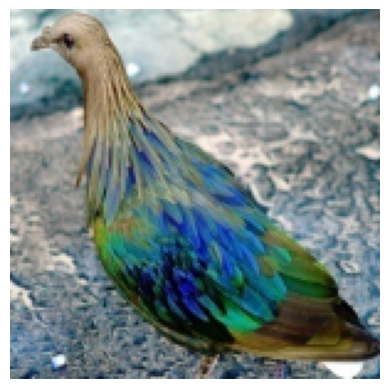

predict: NICOBAR PIGEON actual: NICOBAR PIGEON


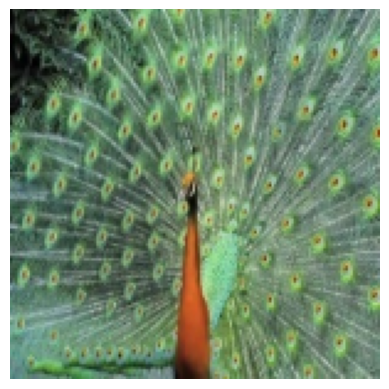

predict: PEACOCK actual: PEACOCK


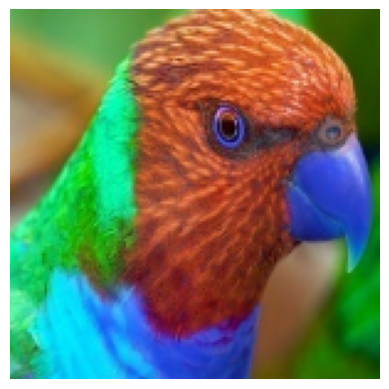

predict: RAINBOW LORIKEET actual: RAINBOW LORIKEET


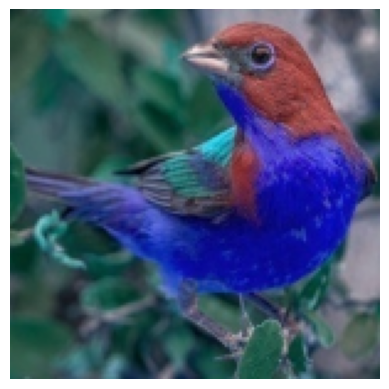

predict: LILAC ROLLER actual: PAINTED BUNTIG


In [38]:
#-----------------------------------------------------------
# Pass images for prediction
#-----------------------------------------------------------

from tensorflow.keras.preprocessing import image
import numpy as np
import random

for i in range(5):
    choice = random.randint(0,9)
    dir = rdirs[choice]
    files=os.listdir(os.path.join(test_path, dir))
    img = random.choice(files)
    a = cv2.imread(test_path+'/'+dir+'/'+img)  
    a = cv2.resize(a,(150,150))
    plt.imshow(a)
    plt.axis("off")
    plt.show()
    a = np.array(a/255)
    answer = saved_model.predict(np.array([a]))
    pred = np.argmax(answer)
    print("predict:",rdirs[pred],"actual:",rdirs[choice])

In [18]:
#-----------------------------------------------------------
# read the annotation file
#-----------------------------------------------------------

data = pd.read_csv('data_annotations.csv',usecols=['img_names', 'labels', 'class_names'])

In [19]:
#-----------------------------------------------------------
# Feature extraction 
#-----------------------------------------------------------

import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_image_features(image_file_name):
    
    image = load_img(image_file_name, target_size=(150, 150))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    features = cust_model.predict(image)
    
    return features

image_features_list=[]
for img in tqdm(data.img_names):
    image_features=get_image_features(img)
    image_features_list.append(image_features)    

image_features_arr=np.asarray(image_features_list)
del image_features_list # del to get free space
image_features_arr = np.rollaxis(image_features_arr,1,0)
image_features_arr = image_features_arr[0,:,:]
pickle.dump(image_features_arr, open('feature_vectors_1100_samples.pkl', 'wb'))

100%|██████████| 1100/1100 [00:44<00:00, 24.68it/s]


In [20]:
#-----------------------------------------------------------
# define the log dor for saving checkpoints
#-----------------------------------------------------------

LOG_DIR = 'embedding_logs'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

In [21]:
#-----------------------------------------------------------
# prepare meta data file
#-----------------------------------------------------------

data = pd.read_csv('data_annotations.csv',usecols=['img_names', 'labels', 'class_names'])

metadata_file = open(os.path.join(LOG_DIR, 'metadata_10_classes.tsv'), 'w')
metadata_file.write('Class\tName\n')

for label,name in zip(data.labels,data.class_names):
    metadata_file.write('{}\t{}\n'.format(label,name))
metadata_file.close()

In [22]:
#-----------------------------------------------------------
#prepare sprite images 
#-----------------------------------------------------------

img_data=[]
for img in tqdm(data.img_names):
    input_img=cv2.imread(img)
    input_img_resize=cv2.resize(input_img,(150,150))
    img_data.append(input_img_resize) 
img_data = np.array(img_data)

100%|██████████| 1100/1100 [00:01<00:00, 930.32it/s]


In [23]:
#-----------------------------------------------------------
# Taken from: https://github.com/tensorflow/tensorflow/issues/6322
#-----------------------------------------------------------

def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [24]:
sprite = images_to_sprite(img_data)
cv2.imwrite(os.path.join(LOG_DIR, 'sprite_10_classes.png'), sprite)
print('sprite_10_classes.png')

sprite_10_classes.png


In [25]:
#-----------------------------------------------------------
# Load features
#-----------------------------------------------------------
with open('feature_vectors_1100_samples.pkl', 'rb') as f:
    feature_vectors = pickle.load(f)
#feature_vectors = np.loadtxt('feature_vectors_400_samples.txt')
print ("feature_vectors_shape:",feature_vectors.shape)
print ("num of images:",feature_vectors.shape[0])
print ("size of individual feature vector:",feature_vectors.shape[1])

features = tf.Variable(feature_vectors, name='features')

feature_vectors_shape: (1100, 512)
num of images: 1100
size of individual feature vector: 512


In [26]:
#-----------------------------------------------------------
# Create a checkpoint from embedding, the filename and key are name of the tensor
#-----------------------------------------------------------

checkpoint = tf.train.Checkpoint(embedding=features)
checkpoint.save(os.path.join(LOG_DIR, "embedding.ckpt"))

'embedding_logs\\embedding.ckpt-1'

In [27]:
#-----------------------------------------------------------
# Set up config
#-----------------------------------------------------------

from tensorboard.plugins import projector

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path =  'metadata_10_classes.tsv'
embedding.sprite.image_path =  'sprite_10_classes.png'
embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])

projector.visualize_embeddings(LOG_DIR, config)

In [9]:
#%load_ext tensorboard
#%tensorboard --logdir embedding_logs